# 0 Problem Definition

**This notebook is to design a ESG Score based on news data.**

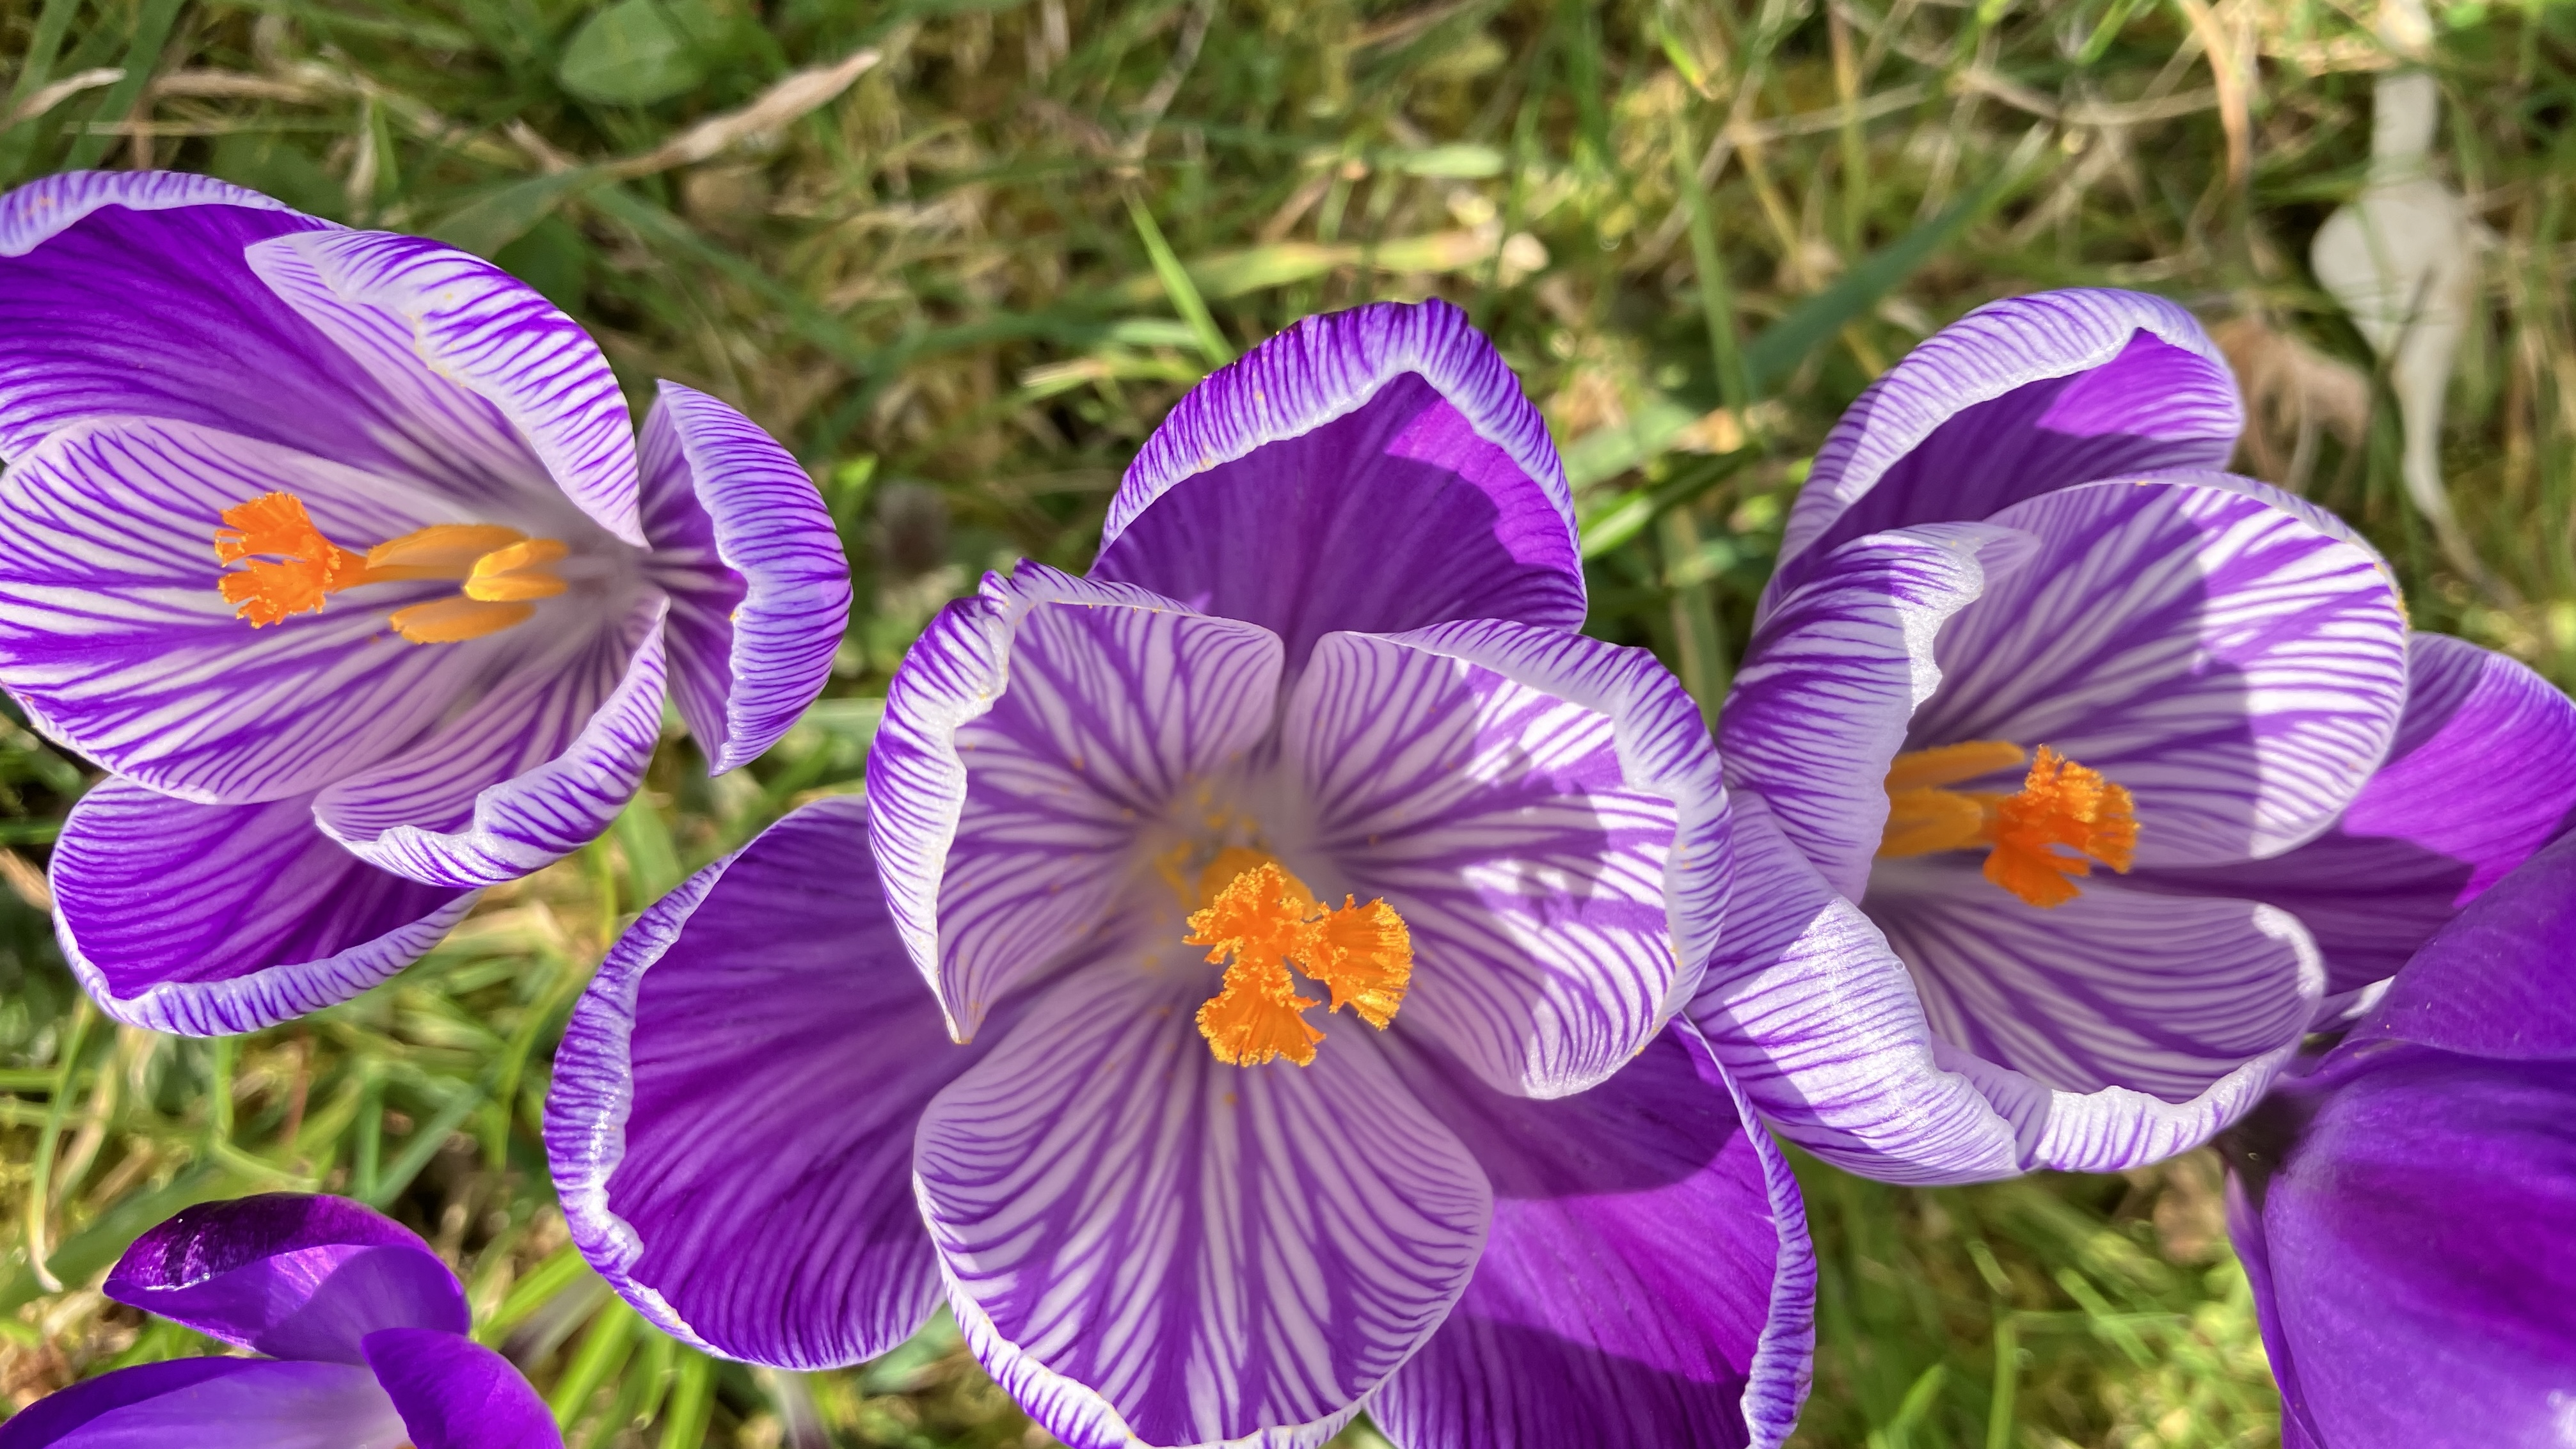

# 1. Load Libraries

In [2]:
# Load libraries
import numpy as np
import pandas as pd
from pandas import read_excel, set_option
from tqdm import tqdm
# pio.renderers.default = 'colab'
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

import pycountry

import plotly
import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.offline as py
py.init_notebook_mode()
import cufflinks
import datetime
# from multiprocessing import Pool, cpu_count
import os
from time import time

from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
# colab plot display
import plotly.io as pio

In [2]:
import pycountry
def Pycountry_2_to_3(alpha_2):
    try:
        return pycountry.countries.get(alpha_2=alpha_2).alpha_3
    except:
        return None

# 2. Load Data

This news dataset is already geolocated. Details see notebook `NewsAPP.ipynb`

Load news articles in ESG topics

In [1]:
df = pd.read_csv('data/esg_news.csv',index_col=0)

NameError: name 'pd' is not defined

In [20]:
df.head(1)

NewsArticleId        date  date_int  Symantic  \
0  4a7b7abe76294d03af981cb377dc29b8  2022-08-22  20220822    0.9975   

   LocationId LocationName CountryCode FeatureCode FeatureClass  \
0   4971068.0        Maine          US        ADM1            A   

   CountryGeoNameId StateCode  StateGeoNameId  Population  Longitude  \
0         6252001.0        ME       4971068.0   1325518.0  -69.24977   

   Latitude  Frequency  Probability  pred_class LocationTypeId CountryCode3  
0  45.50032       17.0       0.7325          10              2          USA

In [21]:
df.isnull().sum()

NewsArticleId            0
date                     0
date_int                 0
Symantic                 0
LocationId               0
LocationName             0
CountryCode            451
FeatureCode           1180
FeatureClass            28
CountryGeoNameId         2
StateCode             2904
StateGeoNameId      138773
Population               0
Longitude                0
Latitude                 0
Frequency                0
Probability              0
pred_class               0
LocationTypeId        1180
CountryCode3           483
dtype: int64

In [22]:
# drop null values in column CountryCode3
df = df.query('CountryCode3 == CountryCode3')

In [23]:
df.shape

(661540, 20)

# 3 EDA

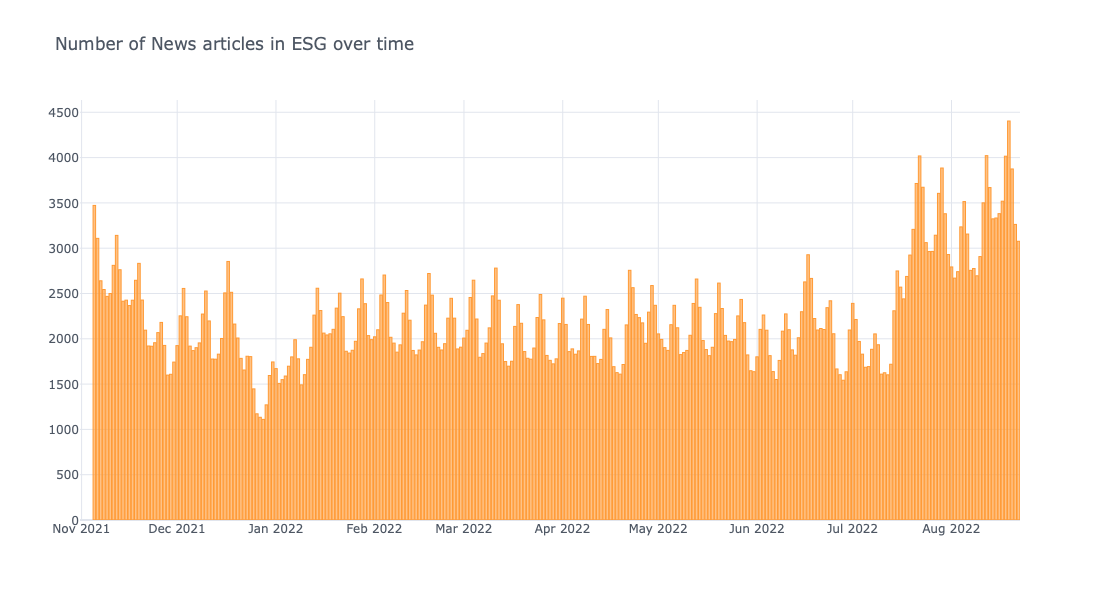

In [25]:
# plot number of news articles overtime
esg = pd.DataFrame(df.groupby(['date'])['NewsArticleId'].count()).reset_index().set_index('date')
esg.rolling(window=5).mean().iplot(kind='bar', title='Number of News articles in ESG over time')

In [26]:
# groupby country over time
def number_country_news(dataset,Code3List):
    countries = pd.DataFrame()
    window_length = 7
    for code in Code3List:
        country = dataset.query('CountryCode3 == "{}"'.format(code))
        country = pd.DataFrame(country.groupby(['date'])['NewsArticleId'].count()).reset_index().set_index('date')\
                                                .rename(columns={'NewsArticleId':'{}'.format(code)}).rolling(window=window_length).mean()
        countries = pd.concat([countries, country],axis=1)
    return countries

In [27]:
# map 3alphabet country code to country name
def Pycountry_3_to_name(alpha_3):
    try:
        return pycountry.countries.get(alpha_3=alpha_3).name
    except:
        return "None"

In [28]:
# display country name
Code3List = ["USA","GBR","CHN","FRA",'DEU','CAN','ITA','JPN','UKR','RUS','LKA','TJK','TWN','ZAF']
for i in Code3List:
    print(Pycountry_3_to_name(i))

United States
United Kingdom
China
France
Germany
Canada
Italy
Japan
Ukraine
Russian Federation
Sri Lanka
Tajikistan
Taiwan, Province of China
South Africa


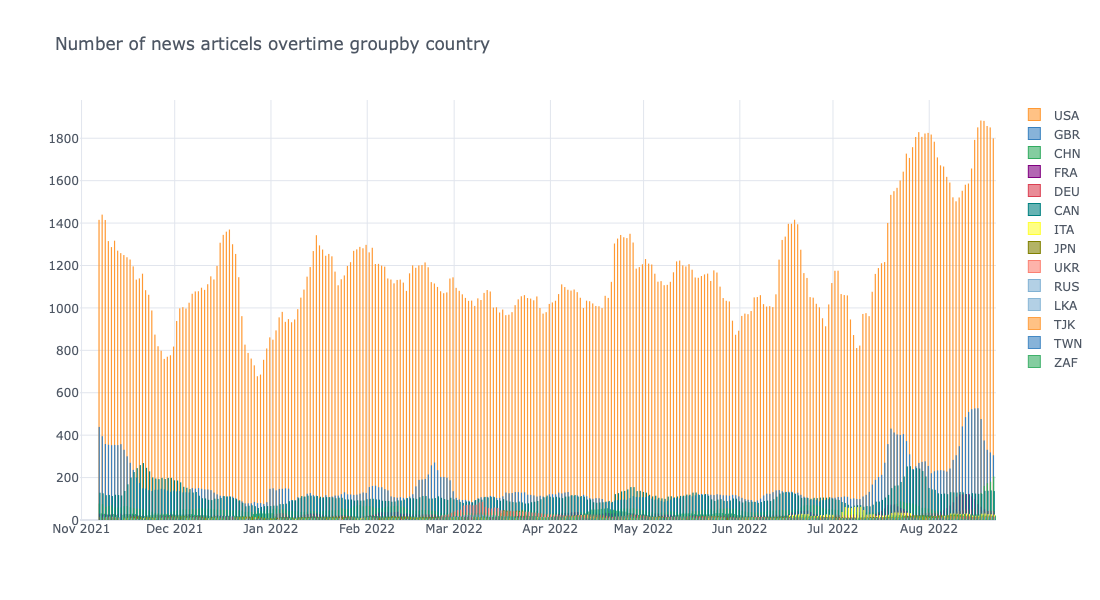

In [29]:
# plot the number of news articles in different country
countries = number_country_news(df,Code3List)
countries.iplot(kind='bar',title = 'Number of news articels overtime groupby country')

In [32]:
# plot number of news in UK and USA
Code3List = ['USA','GBR','AFG','']
countries = number_country_news(df,Code3List)
countries.iplot(kind='bar',title = 'Number of news articels overtime groupby country in UK and USA')

# 4 Design ESG Score

In [33]:
# capital city names
capital_city_names = pd.read_excel('data/capital_city_names.xlsx').iloc[:,:-1]

In [34]:
capital_city_names

country      capital_city
0    Afghanistan             Kabul
1        Albania            Tirana
2        Algeria           Algiers
3        Andorra  Andorra la Vella
4         Angola            Luanda
..           ...               ...
197    Venezuela           Caracas
198      Vietnam             Hanoi
199        Yemen            Sana'a
200       Zambia            Lusaka
201     Zimbabwe            Harare

[202 rows x 2 columns]

In [35]:
# check if location name is capital 
capital_city_names_list = capital_city_names.capital_city.to_list()
df['is_capital'] = df['LocationName'].apply(lambda x : "yes" if x in capital_city_names_list else "no")

In [36]:
df.head(1)

NewsArticleId        date  date_int  Symantic  \
0  4a7b7abe76294d03af981cb377dc29b8  2022-08-22  20220822    0.9975   

   LocationId LocationName CountryCode FeatureCode FeatureClass  \
0   4971068.0        Maine          US        ADM1            A   

   CountryGeoNameId StateCode  StateGeoNameId  Population  Longitude  \
0         6252001.0        ME       4971068.0   1325518.0  -69.24977   

   Latitude  Frequency  Probability  pred_class LocationTypeId CountryCode3  \
0  45.50032       17.0       0.7325          10              2          USA   

  is_capital  
0         no

In [37]:
round(df.query('is_capital =="yes"').shape[0] / df.shape[0], 4)

0.0535

Aound 5.35% locations is capital city. 

* Assign weight 1 to capital city otherwise 0

In [38]:
df['Capital_Weight'] = df['is_capital'].apply(lambda x : 1 if x=="yes" else 0)

In [39]:
df.head(1)

NewsArticleId        date  date_int  Symantic  \
0  4a7b7abe76294d03af981cb377dc29b8  2022-08-22  20220822    0.9975   

   LocationId LocationName CountryCode FeatureCode FeatureClass  \
0   4971068.0        Maine          US        ADM1            A   

   CountryGeoNameId StateCode  StateGeoNameId  Population  Longitude  \
0         6252001.0        ME       4971068.0   1325518.0  -69.24977   

   Latitude  Frequency  Probability  pred_class LocationTypeId CountryCode3  \
0  45.50032       17.0       0.7325          10              2          USA   

  is_capital  Capital_Weight  
0         no               0

* Assign weight 0 if sentiment values lies in (-0.98, +0.98)
* Assign weight +1 if sentiment values > 0.98
* Assign weight -1 if sentiment values > 0.98

In [42]:
# define a funciton a assign weight based on sentiment values
def SA_Weight(x):
    # netural 
    if x < 0.98 and x > -0.98:
        w = 0
    # postive
    elif x > 0.98:
        w = 1
    # negative 
    else:
        w = -1
    return w   

In [43]:
df['SA_Weight'] = df['Symantic'].apply(lambda x : SA_Weight(x))

In [44]:
df.head(1)

NewsArticleId        date  date_int  Symantic  \
0  4a7b7abe76294d03af981cb377dc29b8  2022-08-22  20220822    0.9975   

   LocationId LocationName CountryCode FeatureCode FeatureClass  \
0   4971068.0        Maine          US        ADM1            A   

   CountryGeoNameId StateCode  StateGeoNameId  Population  Longitude  \
0         6252001.0        ME       4971068.0   1325518.0  -69.24977   

   Latitude  Frequency  Probability  pred_class LocationTypeId CountryCode3  \
0  45.50032       17.0       0.7325          10              2          USA   

  is_capital  Capital_Weight  SA_Weight  
0         no               0          1

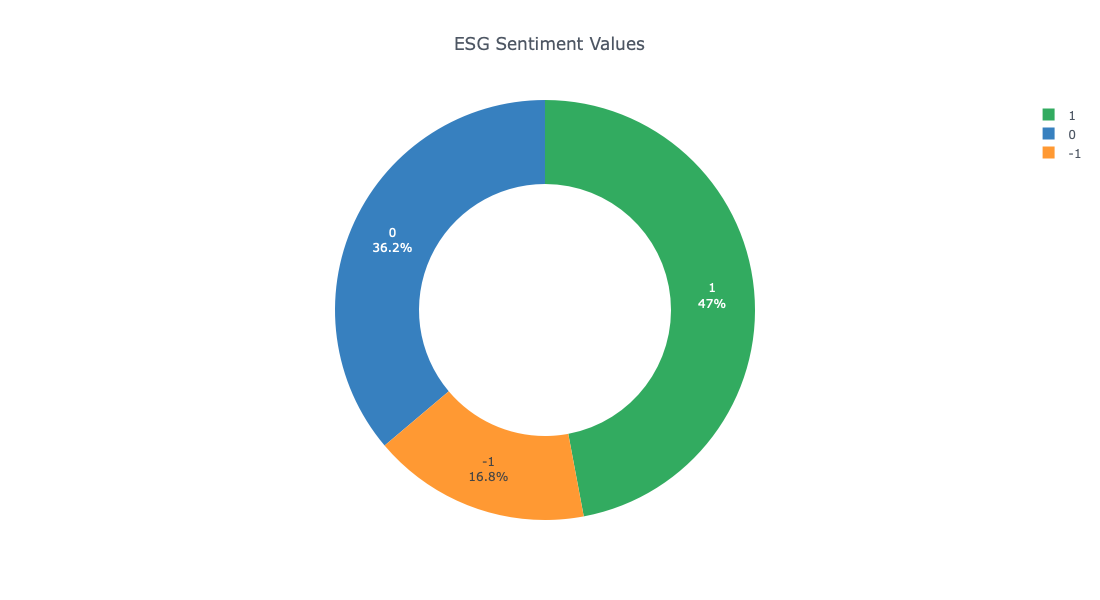

In [46]:
# Plot Sentiment values in percentage
df_polarity = pd.DataFrame(df.groupby(['SA_Weight'])['NewsArticleId'].count())
df_polarity.reset_index().iplot(kind='pie',
                                labels='SA_Weight',
                                values="NewsArticleId",
                                textinfo='percent+label', 
                                hole=.6,title ='ESG Sentiment Values')

The pie chart shows that 47% ESG news articels is positive sentiment, 36.2% is netural and 16.8% is postive sentiment.

* Base weight set as 1, underlying value 1 is the number of news article

In [47]:
df['Base_Weight'] = 1

In [48]:
df.head(1)

NewsArticleId        date  date_int  Symantic  \
0  4a7b7abe76294d03af981cb377dc29b8  2022-08-22  20220822    0.9975   

   LocationId LocationName CountryCode FeatureCode FeatureClass  \
0   4971068.0        Maine          US        ADM1            A   

   CountryGeoNameId StateCode  StateGeoNameId  Population  Longitude  \
0         6252001.0        ME       4971068.0   1325518.0  -69.24977   

   Latitude  Frequency  Probability  pred_class LocationTypeId CountryCode3  \
0  45.50032       17.0       0.7325          10              2          USA   

  is_capital  Capital_Weight  SA_Weight  Base_Weight  
0         no               0          1            1

In [49]:
df.shape

(661540, 24)

In [50]:
G20 = ['CN', 'IN', 'US','ID', 'BR', 'RU', 'JP', 'MX', 'DE', 'TR', 'FR', 'GB', 'IT', 'ZA', 'KR', 'AR', 'CA', 'SA', 'AU']
G20 = [Pycountry_2_to_3(i) for i in G20]

In [51]:
df['G20_Weight'] = df['CountryCode3'].apply(lambda x : 1 if x in G20 else 0)

In [52]:
df.head(1)

NewsArticleId        date  date_int  Symantic  \
0  4a7b7abe76294d03af981cb377dc29b8  2022-08-22  20220822    0.9975   

   LocationId LocationName CountryCode FeatureCode FeatureClass  \
0   4971068.0        Maine          US        ADM1            A   

   CountryGeoNameId StateCode  StateGeoNameId  Population  Longitude  \
0         6252001.0        ME       4971068.0   1325518.0  -69.24977   

   Latitude  Frequency  Probability  pred_class LocationTypeId CountryCode3  \
0  45.50032       17.0       0.7325          10              2          USA   

  is_capital  Capital_Weight  SA_Weight  Base_Weight  G20_Weight  
0         no               0          1            1           1

* Add G20_Weight, Capital_Weight, SA_Weight, Base_Weight

* TODO: Other factors, such as population, country classes (less developed, developed, etc), can be considered to adjust this score.

In [53]:
df['Total_Weight'] = df.apply(lambda x : (x['G20_Weight'] + 
                                          x['Capital_Weight'] + 
                                          x['SA_Weight'] + 
                                          x['Base_Weight']), axis=1) 

In [116]:
# define a funciton to calculate the ESG score groupby time range and country name
def scoring(dataset,Code3List):
    countries = pd.DataFrame()
    window_length = 7
    for code in Code3List:
        country = dataset.query('CountryCode3 == "{}"'.format(code))
        country = pd.DataFrame(country.groupby(['date'])['Total_Weight'].sum()).reset_index().set_index('date')\
                                                .rename(columns={'Total_Weight':'{}'.format(code)}).rolling(window=window_length).mean()
        countries = pd.concat([countries, country],axis=1)
    return countries

In [55]:
Code3List = ["USA","GBR","CHN","FRA",'DEU','CAN','ITA','JPN','UKR','RUS','LKA','TJK','TWN','ZAF']
countries = scoring(df,Code3List)
countries.iplot(kind='bar',title = 'Adjusted ESG Score overtime groupby country')

In [56]:
# plot number of news in Ukraine, Russia and Poland
def compare_country_adj_score(country3code:str):
    Code3List = [country3code]
    adj = scoring(df,Code3List).rename(columns={Code3List[0]:'Adj_'+Code3List[0]})
    ori = number_country_news(df,Code3List)
    conbined = pd.concat([adj, ori],axis=1)
    return conbined

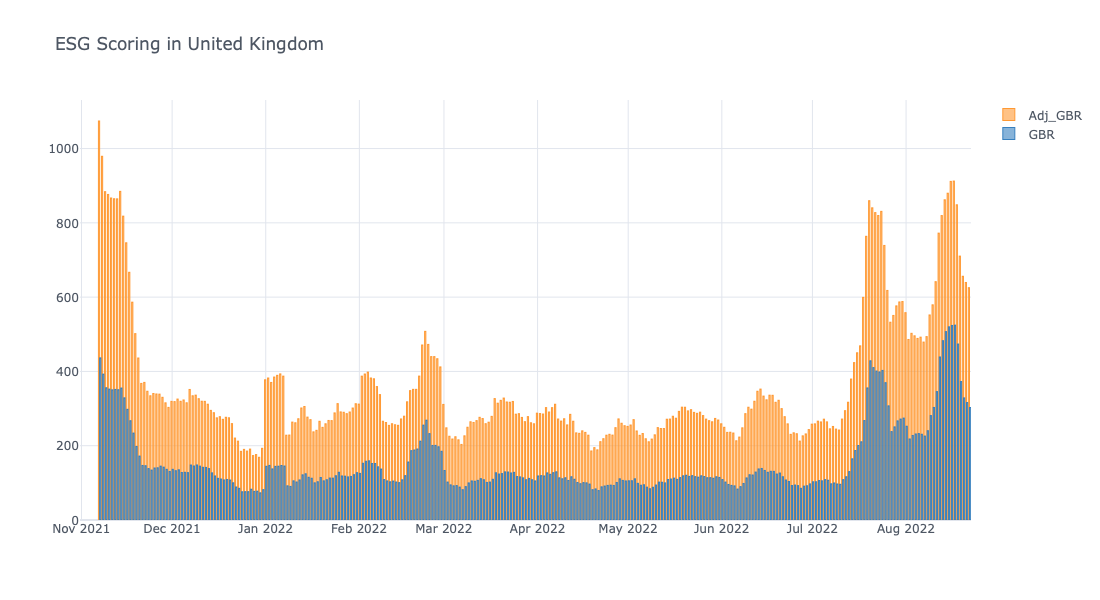

In [115]:
uk_scores = compare_country_adj_score(country3code = "GBR")
uk_scores.iplot(kind = 'bar',title='ESG Scoring in United Kingdom')

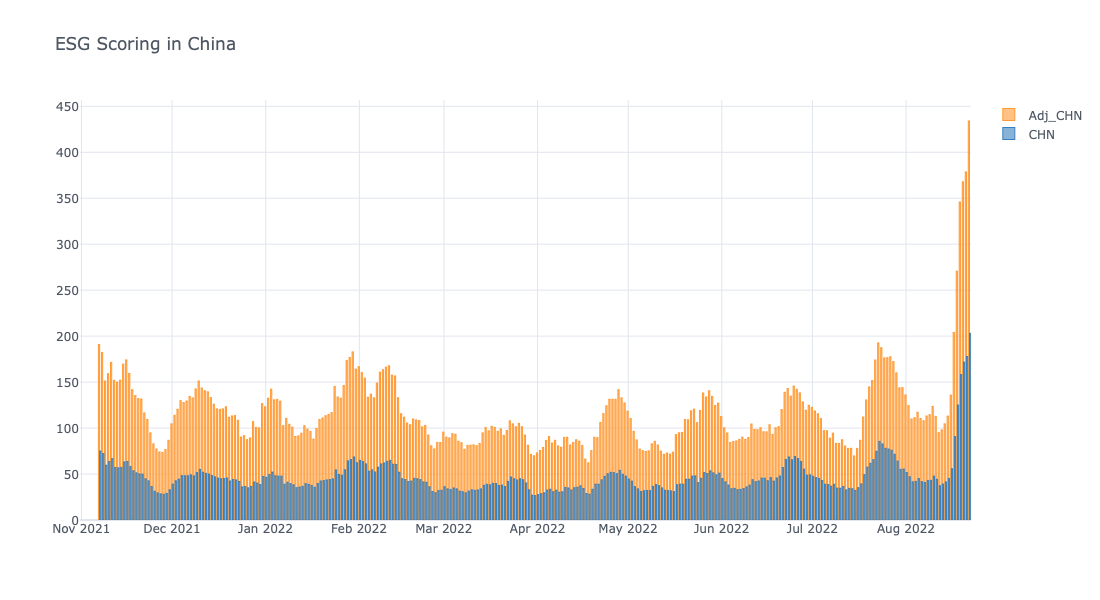

In [59]:
# compare adjusted ESG score with original score
cn_scores = compare_country_adj_score(country3code = "CHN")
cn_scores.iplot(kind = 'bar',title='ESG Scoring in China')

In [60]:
uk_scores.tail(1)

Adj_GBR         GBR
date                              
2022-08-22  625.428571  302.857143

In [62]:
uk_scores

Adj_GBR         GBR
date                              
2021-11-01         NaN         NaN
2021-11-02         NaN         NaN
2021-11-03         NaN         NaN
2021-11-04         NaN         NaN
2021-11-05         NaN         NaN
...                ...         ...
2022-08-18  848.571429  473.714286
2022-08-19  710.428571  372.714286
2022-08-20  656.142857  328.714286
2022-08-21  639.428571  316.142857
2022-08-22  625.428571  302.857143

[295 rows x 2 columns]

In [68]:
cn_scores

Adj_CHN         CHN  adj_chg_rus  adj_chg_chn
date                                                        
2021-11-01         NaN         NaN          NaN          NaN
2021-11-02         NaN         NaN          NaN          NaN
2021-11-03         NaN         NaN          NaN          NaN
2021-11-04         NaN         NaN          NaN          NaN
2021-11-05         NaN         NaN          NaN          NaN
...                ...         ...          ...          ...
2022-08-18  270.571429  125.000000     0.326331     0.326331
2022-08-19  345.857143  158.285714     0.278247     0.278247
2022-08-20  367.857143  171.714286     0.063610     0.063610
2022-08-21  378.571429  177.857143     0.029126     0.029126
2022-08-22  434.000000  203.000000     0.146415     0.146415

[295 rows x 4 columns]

In [69]:
uk_scores['adj_chg_ukr'] = uk_scores['Adj_GBR'].pct_change(1)
cn_scores['adj_chg_chn'] = cn_scores['Adj_CHN'].pct_change(1)

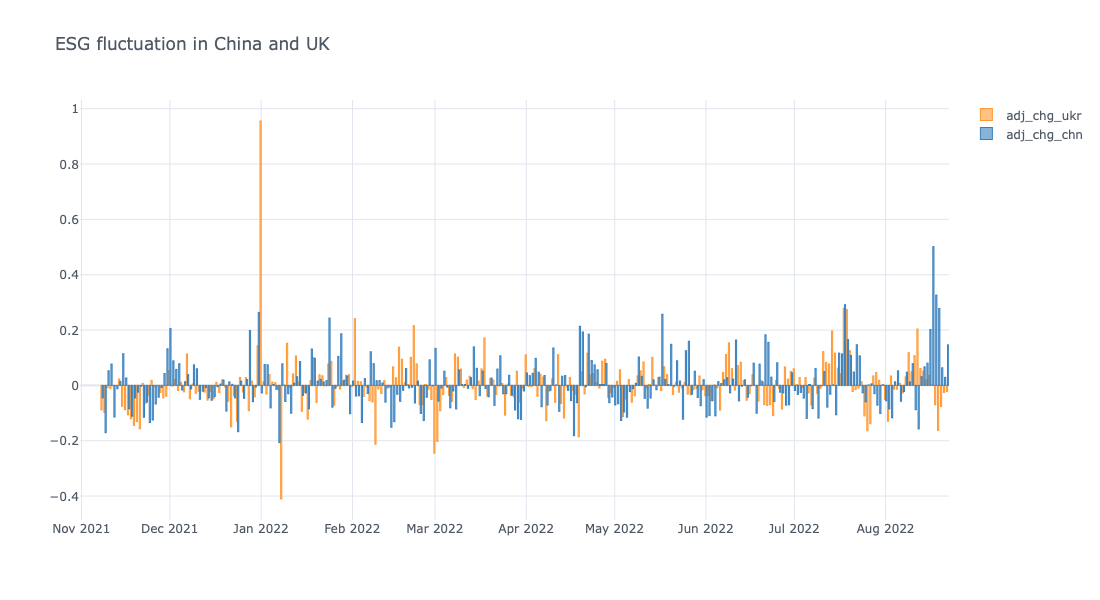

In [71]:
# plot ESG one day percentage change
pd.concat([uk_scores[['adj_chg_ukr']], cn_scores[['adj_chg_chn']]], axis=1)\
                                    .iplot(kind='bar',title='ESG fluctuation in China and UK')

In [72]:
# G20 countries
G20 = ['CN', 'IN', 'US','ID', 'BR', 'RU', 'JP', 'MX', 'DE', 'TR', 'FR', 'GB', 'IT', 'ZA', 'KR', 'AR', 'CA', 'SA', 'AU']
G20 = [Pycountry_2_to_3(i) for i in G20]
print(G20)

['CHN', 'IND', 'USA', 'IDN', 'BRA', 'RUS', 'JPN', 'MEX', 'DEU', 'TUR', 'FRA', 'GBR', 'ITA', 'ZAF', 'KOR', 'ARG', 'CAN', 'SAU', 'AUS']


In [73]:
df.head(1)

NewsArticleId        date  date_int  Symantic  \
0  4a7b7abe76294d03af981cb377dc29b8  2022-08-22  20220822    0.9975   

   LocationId LocationName CountryCode FeatureCode FeatureClass  \
0   4971068.0        Maine          US        ADM1            A   

   CountryGeoNameId StateCode  StateGeoNameId  Population  Longitude  \
0         6252001.0        ME       4971068.0   1325518.0  -69.24977   

   Latitude  Frequency  Probability  pred_class LocationTypeId CountryCode3  \
0  45.50032       17.0       0.7325          10              2          USA   

  is_capital  Capital_Weight  SA_Weight  Base_Weight  G20_Weight  Total_Weight  
0         no               0          1            1           1             3

In [74]:
# groupby date
pd.DataFrame(df.groupby(['date','CountryCode3'])['Total_Weight'].sum())

Total_Weight
date       CountryCode3              
2021-11-01 AFG                      7
           AGO                      2
           ARG                     10
           ATA                      0
           AUS                    187
...                               ...
2022-08-22 UZB                      4
           VNM                     25
           ZAF                     90
           ZMB                     14
           ZWE                      6

[21252 rows x 1 columns]

In [75]:
# calculate the sum of total weight groupy by date and country
total_weight_sum = pd.DataFrame(df.groupby(['date','CountryCode3'])['Total_Weight'].sum()).\
                    reset_index().set_index('date').rename(columns={'Total_Weight' : 'total_weight_sum'}).reset_index()
total_weight_sum

date CountryCode3  total_weight_sum
0      2021-11-01          AFG                 7
1      2021-11-01          AGO                 2
2      2021-11-01          ARG                10
3      2021-11-01          ATA                 0
4      2021-11-01          AUS               187
...           ...          ...               ...
21247  2022-08-22          UZB                 4
21248  2022-08-22          VNM                25
21249  2022-08-22          ZAF                90
21250  2022-08-22          ZMB                14
21251  2022-08-22          ZWE                 6

[21252 rows x 3 columns]

In [90]:
# define a function to calcute the ESG score, which is sum of total weight of a single country  devided by 
# the sum of total weight in G20
def TotalWeight_by_G20sum(dataset):
    new_dataset = pd.DataFrame()
    date_list = list(dataset.date.unique())
    for date in date_list:
        daily = dataset.query('date == "{}"'.format(date))
        daily['all_country_weight_avg'] = daily['total_weight_sum'].mean()
        daily['is_G20'] = daily['CountryCode3'].apply(lambda x : 1 if x in G20 else 0)
        daily['G20_sum'] = daily.query('is_G20==1')['total_weight_sum'].sum()
        daily['Score'] = round(daily['total_weight_sum'] / daily['G20_sum'],3) * 100
       
        new_dataset = pd.concat([new_dataset, daily],ignore_index=True)

    return new_dataset.set_index(['date'])

In [91]:
df_benchMark = TotalWeight_by_G20sum(total_weight_sum)
df_benchMark

CountryCode3  total_weight_sum  all_country_weight_avg  is_G20  \
date                                                                        
2021-11-01          AFG                 7              109.355263       0   
2021-11-01          AGO                 2              109.355263       0   
2021-11-01          ARG                10              109.355263       1   
2021-11-01          ATA                 0              109.355263       0   
2021-11-01          AUS               187              109.355263       1   
...                 ...               ...                     ...     ...   
2022-08-22          UZB                 4               92.555556       0   
2022-08-22          VNM                25               92.555556       0   
2022-08-22          ZAF                90               92.555556       1   
2022-08-22          ZMB                14               92.555556       0   
2022-08-22          ZWE                 6               92.555556       0   

            G20_sum  Score  
date                        
2021-11-01     7873    0.1  
2021-11-01     7873    0.0  
2021-11-01     7873    0.1  
2021-11-01     7873    0.0  
2021-11-01     7873    2.4  
...             ...    ...  
2022-08-22     7621    0.1  
2022-08-22     7621    0.3  
2022-08-22     7621    1.2  
2022-08-22     7621    0.2  
2022-08-22     7621    0.1  

[21252 rows x 6 columns]

In [95]:
Code3List = ["USA","GBR","CHN","FRA",'DEU','CAN','ITA','JPN','UKR','RUS','LKA','ETH']
G20_BM= pd.DataFrame()

for i in Code3List:
    df_20 = df_benchMark.query('CountryCode3 == "{}"'.format(i))
    df_20 = df_20[['Score']].rolling(window=7).mean()
    df_20 = df_20.rename(columns = {'Score':i})
    G20_BM = pd.concat([G20_BM, df_20],axis=1)

In [96]:
# ESG scores
G20_BM

USA        GBR       CHN       FRA       DEU       CAN  \
date                                                                       
2021-11-01        NaN        NaN       NaN       NaN       NaN       NaN   
2021-11-02        NaN        NaN       NaN       NaN       NaN       NaN   
2021-11-03        NaN        NaN       NaN       NaN       NaN       NaN   
2021-11-04        NaN        NaN       NaN       NaN       NaN       NaN   
2021-11-05        NaN        NaN       NaN       NaN       NaN       NaN   
...               ...        ...       ...       ...       ...       ...   
2022-08-18  57.728571  12.942857  3.328571  1.785714  1.171429  4.157143   
2022-08-19  57.985714  11.157143  4.385714  1.571429  1.042857  4.714286   
2022-08-20  58.342857   9.885714  5.200000  1.328571  1.185714  4.828571   
2022-08-21  59.057143   9.457143  5.585714  0.828571  1.285714  4.942857   
2022-08-22  58.442857   9.414286  6.357143  0.771429  1.228571  4.857143   

                 ITA       JPN       UKR       RUS       LKA       ETH  
date                                                                    
2021-11-01       NaN       NaN       NaN       NaN       NaN       NaN  
2021-11-02       NaN       NaN       NaN       NaN       NaN       NaN  
2021-11-03       NaN       NaN       NaN       NaN       NaN       NaN  
2021-11-04       NaN       NaN       NaN       NaN       NaN       NaN  
2021-11-05       NaN       NaN       NaN       NaN       NaN       NaN  
...              ...       ...       ...       ...       ...       ...  
2022-08-18  0.714286  0.471429  0.071429  0.228571       NaN  0.214286  
2022-08-19  0.728571  0.500000  0.057143  0.228571       NaN  0.271429  
2022-08-20  0.557143  0.385714  0.057143  0.257143  0.042857       NaN  
2022-08-21  0.528571  0.428571  0.057143  0.242857       NaN       NaN  
2022-08-22  0.514286  0.385714  0.071429  0.257143  0.042857  0.271429  

[295 rows x 12 columns]

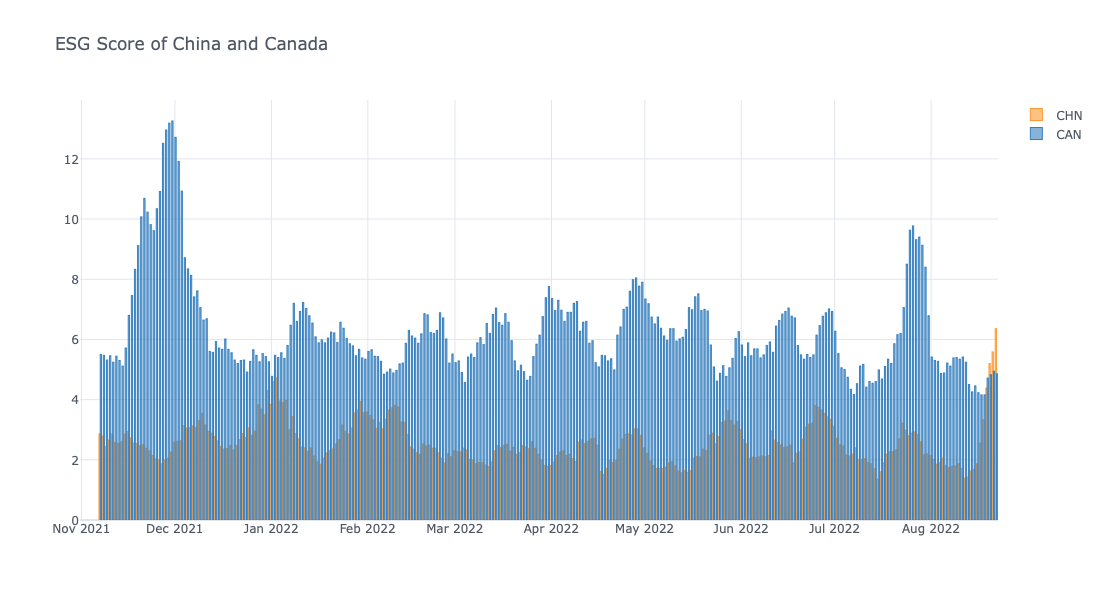

In [100]:
# plot the ESG score in China and Canada, where the benchmark is the sum of total weight in G20
G20_BM[['CHN','CAN']].iplot(kind = 'bar', title = 'ESG Score of China and Canada')

In [82]:
for i in ['LKA','GBR','CAN']:
    print(Pycountry_3_to_name(i))

Sri Lanka
United Kingdom
Canada


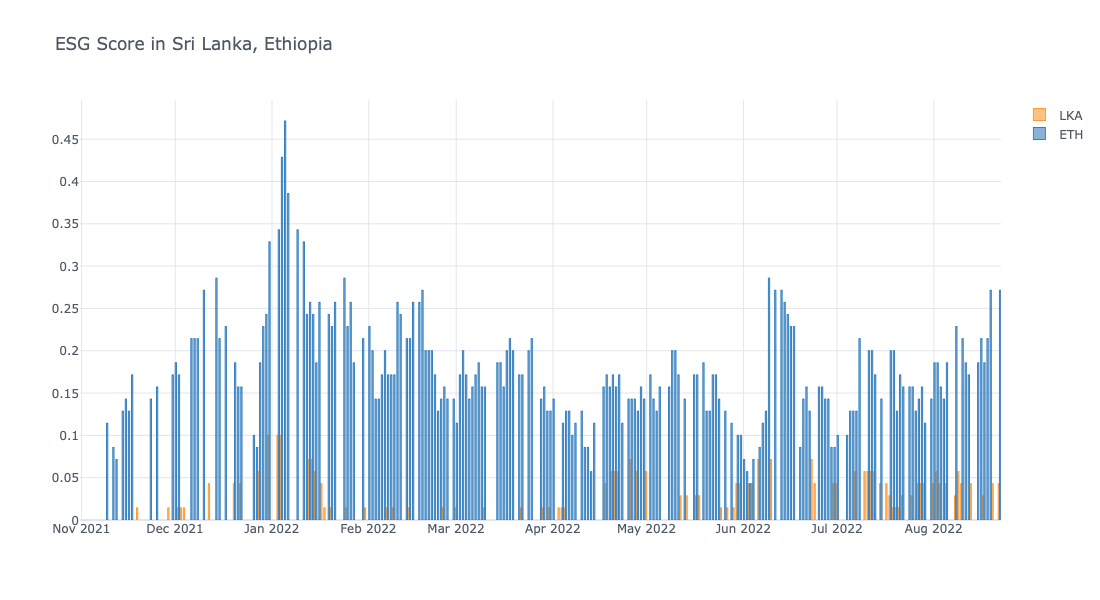

In [104]:
# plot ESG score in Sri Lanka, Ethiopia 
Con_G20_BM[['LKA','ETH']].iplot(kind = 'bar', title = 'ESG Score in Sri Lanka, Ethiopia')

In [106]:
# ESG score in UKR, RUS and USA
ccu = G20_BM[['CAN','CHN','USA']]

# five-days moving average
ccu['CAN_MV'] = ccu['CAN'].rolling(window = 5).mean()
ccu['CHN_MV'] = ccu['CHN'].rolling(window = 5).mean()
ccu['USA_MV'] = ccu['USA'].rolling(window = 5).mean()

# five-days percentage change
ccu['CAN_CHG'] = ccu['CAN'].pct_change(5)
ccu['CHN_CHG'] = ccu['CHN'].pct_change(5)
ccu['USA_CHG'] = ccu['USA'].pct_change(5)

ccu

CAN       CHN        USA    CAN_MV    CHN_MV     USA_MV  \
date                                                                       
2021-11-01       NaN       NaN        NaN       NaN       NaN        NaN   
2021-11-02       NaN       NaN        NaN       NaN       NaN        NaN   
2021-11-03       NaN       NaN        NaN       NaN       NaN        NaN   
2021-11-04       NaN       NaN        NaN       NaN       NaN        NaN   
2021-11-05       NaN       NaN        NaN       NaN       NaN        NaN   
...              ...       ...        ...       ...       ...        ...   
2022-08-18  4.157143  3.328571  57.728571  4.251429  2.214286  57.257143   
2022-08-19  4.714286  4.385714  57.985714  4.342857  2.765714  57.508571   
2022-08-20  4.828571  5.200000  58.342857  4.417143  3.468571  57.774286   
2022-08-21  4.942857  5.585714  59.057143  4.560000  4.211429  58.082857   
2022-08-22  4.857143  6.357143  58.442857  4.700000  4.971429  58.311429   

             CAN_CHG   CHN_CHG   USA_CHG  
date                                      
2021-11-01       NaN       NaN       NaN  
2021-11-02       NaN       NaN       NaN  
2021-11-03       NaN       NaN       NaN  
2021-11-04       NaN       NaN       NaN  
2021-11-05       NaN       NaN       NaN  
...              ...       ...       ...  
2022-08-18 -0.076190  1.330000  0.002978  
2022-08-19  0.107383  1.692982  0.022161  
2022-08-20  0.083333  2.084746  0.023302  
2022-08-21  0.168919  1.984733  0.026826  
2022-08-22  0.168385  1.486034  0.019945  

[295 rows x 9 columns]

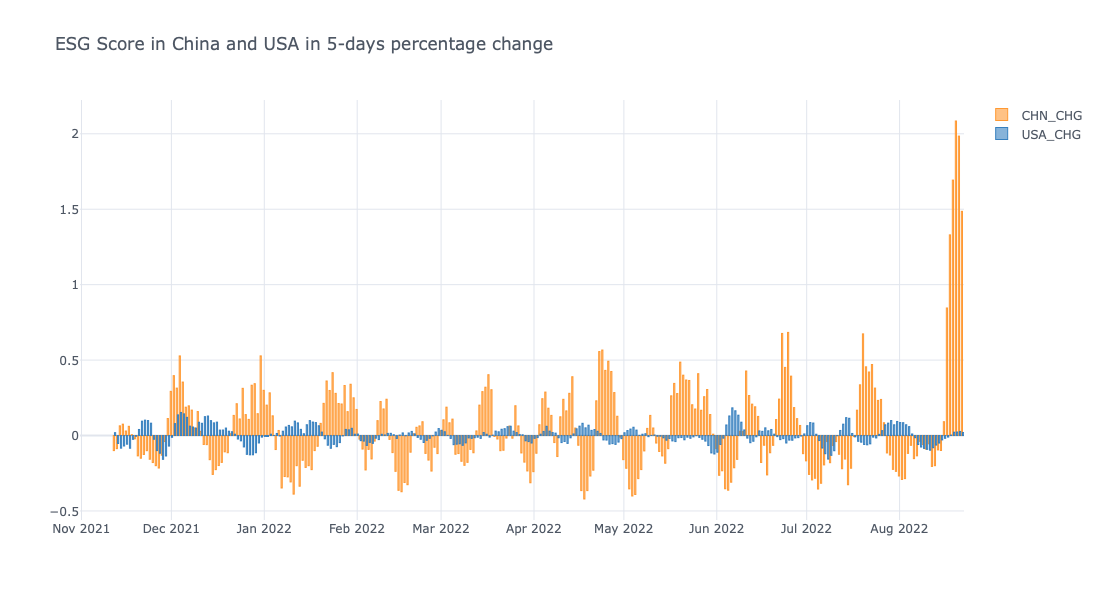

In [110]:
ccu[['CHN_CHG','USA_CHG']].iplot(kind='bar', title = 'ESG Score in China and USA in 5-days percentage change')

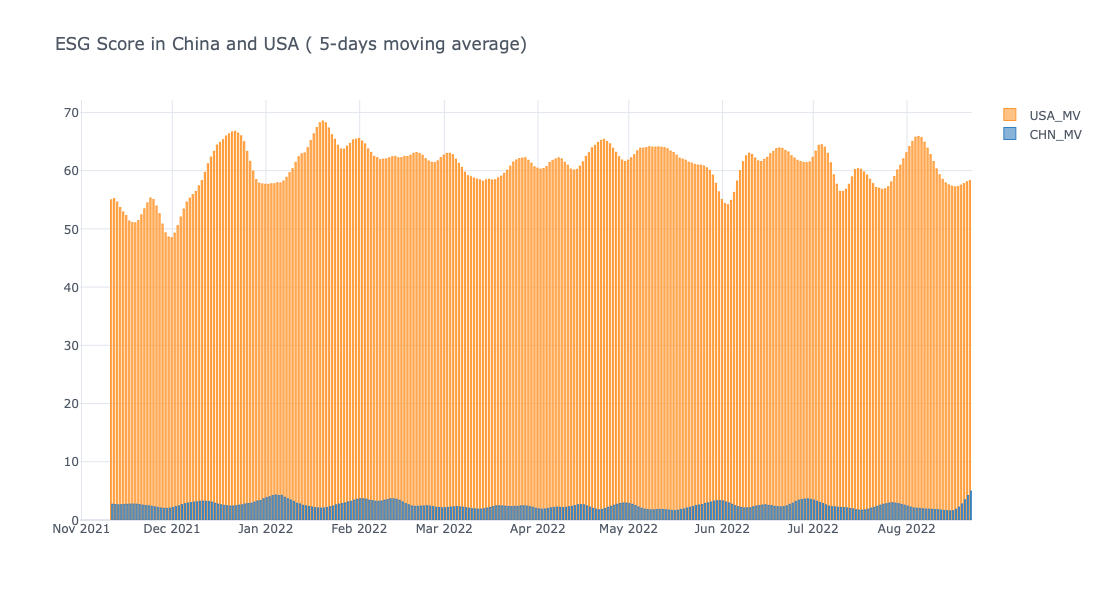

In [111]:
ccu[['USA_MV','CHN_MV']].iplot(kind='bar', title = 'ESG Score in China and USA ( 5-days moving average)')

Plot ESG score in choropleth

In [113]:
df_benchMark['country_name'] = df_benchMark['CountryCode3'].apply(lambda x : Pycountry_3_to_name(x))
df_benchMark.reset_index()

date CountryCode3  total_weight_sum  all_country_weight_avg  \
0      2021-11-01          AFG                 7              109.355263   
1      2021-11-01          AGO                 2              109.355263   
2      2021-11-01          ARG                10              109.355263   
3      2021-11-01          ATA                 0              109.355263   
4      2021-11-01          AUS               187              109.355263   
...           ...          ...               ...                     ...   
21247  2022-08-22          UZB                 4               92.555556   
21248  2022-08-22          VNM                25               92.555556   
21249  2022-08-22          ZAF                90               92.555556   
21250  2022-08-22          ZMB                14               92.555556   
21251  2022-08-22          ZWE                 6               92.555556   

       is_G20  G20_sum  Score  country_name  
0           0     7873    0.1   Afghanistan  
1           0     7873    0.0        Angola  
2           1     7873    0.1     Argentina  
3           0     7873    0.0    Antarctica  
4           1     7873    2.4     Australia  
...       ...      ...    ...           ...  
21247       0     7621    0.1    Uzbekistan  
21248       0     7621    0.3      Viet Nam  
21249       1     7621    1.2  South Africa  
21250       0     7621    0.2        Zambia  
21251       0     7621    0.1      Zimbabwe  

[21252 rows x 8 columns]

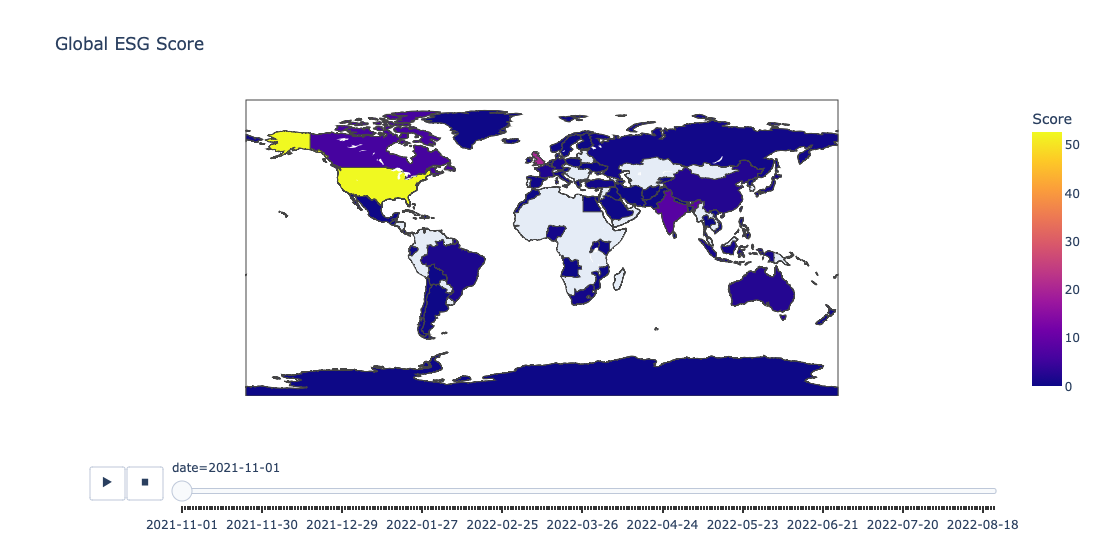

In [114]:
fig = px.choropleth(df_benchMark.reset_index(), locations="CountryCode3",
                    color="Score", hover_name="country_name", animation_frame="date",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    width = 1100,height = 550,
                    title = 'Global ESG Score')
fig.show()